# Import Libraries

In [1]:
import os
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
import imageio
import matplotlib.pyplot as plt
import torch
import torchvision

# Utils

In [5]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def fig(*imgs):
    """color mode: 'gray' or None"""
    num_imgs = len(imgs)
    if num_imgs>2:
        _, axs = plt.subplots(num_imgs, 1)
        for i in range(num_imgs):
            axs[i].imshow(imgs[i]);axs[i].set_axis(False)
    else:
        plt.imshow(imgs[0], 'gray');plt.axis(False)    

def load_data(path):
    train_x = sorted(glob(os.path.join(path, "training", "images", "*.tif")))
    train_y = sorted(glob(os.path.join(path, "training", "1st_manual", "*.gif")))

    test_x = sorted(glob(os.path.join(path, "test", "images", "*.tif")))
    test_y = sorted(glob(os.path.join(path, "test", "1st_manual", "*.gif")))

    return (train_x, train_y), (test_x, test_y)

def create_patches_for_an_image(img_path, patch_size=128):
    """it makes an image grid and returns a variable of this image's patches"""

    img = torchvision.io.read_image(img_path)

    C, H, W = img.shape
    n_rows = H // patch_size
    n_cols = W // patch_size

    cropped_img = img[:, :n_rows * patch_size, :n_cols * patch_size]

    patches = torch.empty(C, n_rows, n_cols, patch_size, patch_size)
    for chan in range(C):
        patches[chan, ...] = (
            cropped_img[chan, ...]
            .reshape(n_rows, patch_size, n_cols, patch_size)
            .permute(0, 2, 1, 3)
        )
    return patches


def save_patches_of_an_image(patches, save_dir, image_name):
    _, n_rows, n_cols, _, _ = patches.shape
    base_name = image_name.split(".")[0]
    for row in range(n_rows):
        for col in range(n_cols):
            save_path = os.path.join(save_dir, f"{base_name}_{row}_{col}.png")
            torchvision.utils.save_image(
                patches[:, row, col]/255, save_path
            )

def patch_builder(image_paths, save_folder, patch_size=128):
    for img_path in image_paths:
        patches = create_patches_for_an_image(img_path, patch_size)
        save_patches_of_an_image(patches, save_folder, img_path.split("/")[-1])
    

# Generate patches and save them

In [30]:
path = "./data/DRIVE/"
create_dir(path+"patches/train/images")
create_dir(path+"patches/test/images")
create_dir(path+"patches/train/masks")
create_dir(path+"patches/test/masks")

In [45]:
train_x = sorted(glob(path+'train-png/images/*'))
train_y = sorted(glob(path+'train-png/masks/*'))
test_x = sorted(glob(path+'test-png/images/*'))
test_y = sorted(glob(path+'test-png/masks/*'))
###
# create patches for train dataset
###
for x, y in tqdm(zip(train_x, train_y)):
    name = x.split("/")[-1].split(".")[0]
    # images
    patches_x = create_patches_for_an_image(x)
    save_patches_of_an_image(patches_x, path+'patches/train/images/', name)
    # masks
    patches_y = create_patches_for_an_image(y)
    save_patches_of_an_image(patches_y, path+'patches/train/masks/', name)
###
# create patches for test dataset
###   
for x, y in tqdm(zip(test_x, test_y)):
    name = x.split("/")[-1].split(".")[0]
    # images
    patches_x = create_patches_for_an_image(x)
    save_patches_of_an_image(patches_x, path+'patches/test/images/', name)
    # masks
    patches_y = create_patches_for_an_image(y)
    save_patches_of_an_image(patches_y, path+'patches/test/masks/', name)

20it [01:16,  3.81s/it]
20it [01:15,  3.75s/it]


# Plot

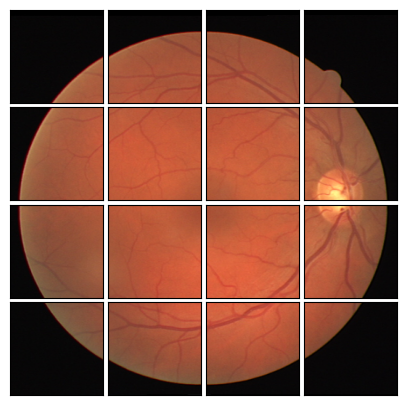

In [46]:
# patches = create_patches_for_an_image('data/Drive/test-png/image/01_test.png')
patches = patches_x
_, n_rows, n_cols, _, _ = patches.shape

#
#Plot
#
f, axs = plt.subplots(n_rows, n_cols, figsize=(5, 5))

for row_idx in range(n_rows):
    for col_idx in range(n_cols):
        axs[row_idx, col_idx].imshow(patches[:, row_idx, col_idx, ...].permute(1,2,0) / 255)

for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
f.subplots_adjust(wspace=0.05, hspace=0.05)